In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
sns.set_theme()

df = pd.read_csv('Homework1_TSA130.csv')
print(df.isna().sum())
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')
df.head()
df_test = df.iloc[-12:]
df_train = df.iloc[:-12]

Number of Passengers (x1000)    14
Date                            14
dtype: int64


### I. Visualize the data, check for strange values, and identify trends or seasonality visually.

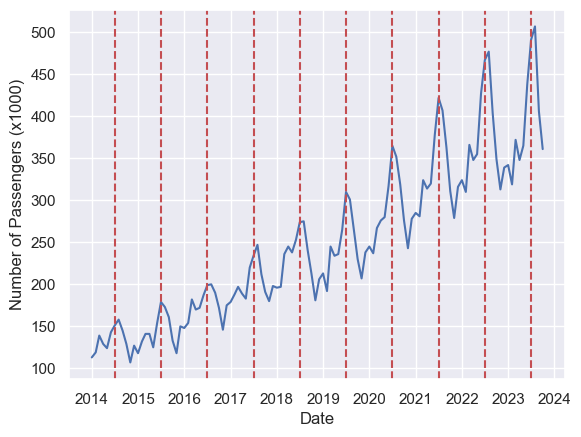

In [277]:
sns.lineplot(df_train, x='Date', y='Number of Passengers (x1000)')
for year in df_train['Date'].dt.year.unique():
    plt.axvline(pd.Timestamp(year, 7, 1), color='r', linestyle='--')

In the above graph we can see a growing trend, furthermore it is easy to identify some sort of seasonality. The seasonality seem to have a period of 12 months, with a consistent peak in July (7th month).

### II. Stationarity testing

In [278]:
# Using Augmented Dickey-Fuller test to check for stationarity
_, pvalue, _, _, critical_values, _ = sm.tsa.stattools.adfuller(df_train['Number of Passengers (x1000)'])
print(f'p-value: {pvalue} >> 0.05 => we cannot reject the null hypothesis that the data is non-stationary.')

p-value: 0.9378629006405318 >> 0.05 => we cannot reject the null hypothesis that the data is non-stationary.


In [279]:
# Using Kwiatkowski-Phillips-Schmidt-Shin test to check for stationarity
_, pvalue, _, _ = sm.tsa.stattools.kpss(df_train['Number of Passengers (x1000)'])
print(f'p-value < {pvalue} < 0.05 => we reject the null hypothesis that the data is stationary.')

p-value < 0.01 < 0.05 => we reject the null hypothesis that the data is stationary.


C:\Users\Albin\AppData\Local\Temp\ipykernel_82088\2143889525.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  _, pvalue, _, _ = sm.tsa.stattools.kpss(df_train['Number of Passengers (x1000)'])


### III. Time Series Modeling: Exponential Smoothing Model

                           ExponentialSmoothing Model Results                           
Dep. Variable:     Number of Passengers (x1000)   No. Observations:                  118
Model:                     ExponentialSmoothing   SSE                          13464.021
Optimized:                                 True   AIC                            590.977
Trend:                                 Additive   BIC                            635.308
Seasonal:                        Multiplicative   AICC                           597.886
Seasonal Periods:                            12   Date:                 Fri, 01 Nov 2024
Box-Cox:                                  False   Time:                         19:03:14
Box-Cox Coeff.:                            None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.285

<Axes: xlabel='Date', ylabel='Number of Passengers (x1000)'>

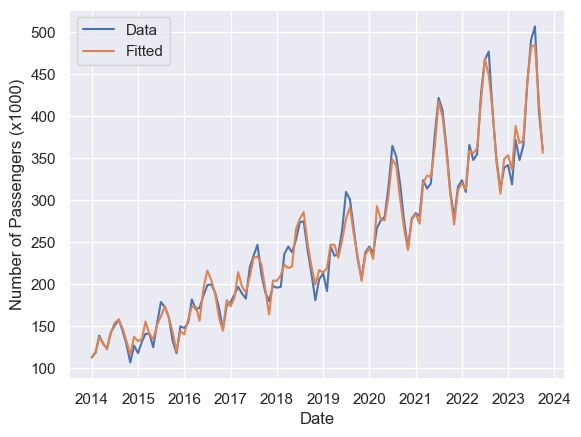

In [280]:
# We use exponential smoothing to fit the data, and the paramaters are optimized automatically by maximizing the log-likelihood
model = sm.tsa.ExponentialSmoothing(df_train['Number of Passengers (x1000)'], trend='add', seasonal='mul',seasonal_periods=12).fit(optimized=True)
print(model.summary())
model.fittedvalues
# Plot the training data and the fitted values
ax = sns.lineplot(df_train, x='Date', y='Number of Passengers (x1000)', label='Data')
sns.lineplot(x=df_train['Date'], y=model.fittedvalues, label='Fitted', ax=ax)

<Axes: xlabel='Date', ylabel='None'>

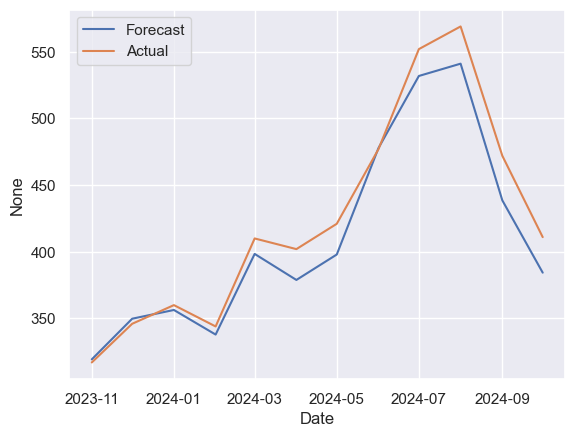

In [281]:
# Forecast the next 12 months
forecast = model.forecast(12)
# Plot the forecast
sns.lineplot(x=df_test['Date'], y=forecast, label='Forecast')
sns.lineplot(x=df_test['Date'], y=df_test['Number of Passengers (x1000)'], label='Actual')

In [282]:
exp_smoothing = model

### III. Time Series Modeling: SARIMA

C:\Users\Albin\AppData\Local\Temp\ipykernel_82088\1500859676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['differenced'] = df_train['Number of Passengers (x1000)'].diff()


Ellipsis

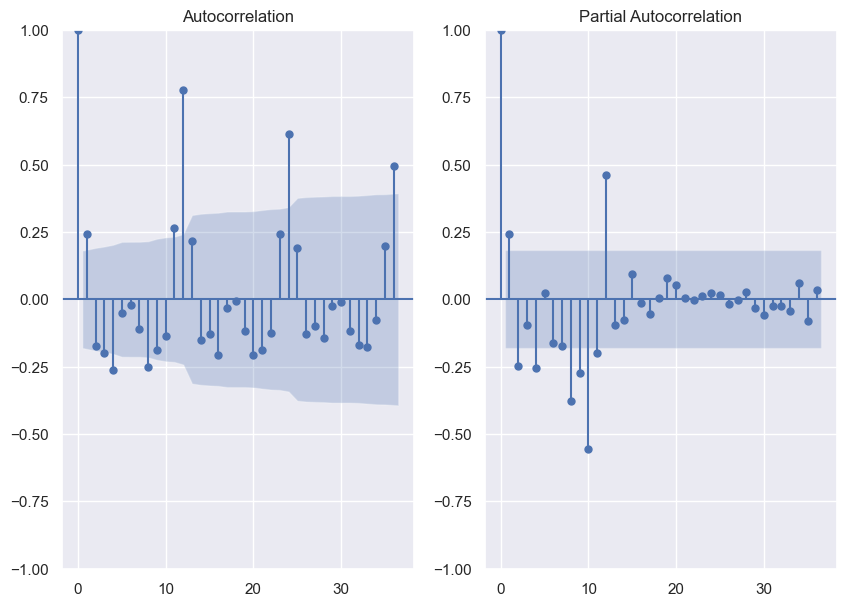

In [283]:
# Check the ACF and PACF
df_train['differenced'] = df_train['Number of Passengers (x1000)'].diff()
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sm.graphics.tsa.plot_acf(df_train['differenced'], lags=36, ax=ax[0], missing='drop')
sm.graphics.tsa.plot_pacf(df_train['differenced'].dropna(), lags=36, ax=ax[1])
...

PACF shows strong correlations for 1 and 2, plus a little for 3. Thus it may be an AR(2) process.

ACF shows strong correlations for all values. This is similar to what we saw when we disucussed random walks.

In [284]:
sarima = sm.tsa.arima.ARIMA(df_train['Number of Passengers (x1000)'], order=(3, 0, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:     Number of Passengers (x1000)   No. Observations:                  118
Model:             ARIMA(3, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -409.156
Date:                          Fri, 01 Nov 2024   AIC                            832.311
Time:                                  19:03:17   BIC                            850.956
Sample:                                       0   HQIC                           839.868
                                          - 118                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4408      0.240      5.992      0.000       0.970       1.912
ar.L2         -0.3096      0.189     -1.638      0.101      -0.680       0.061
ar.L3         -0.1402      0.154     -0.909      0.363      -0.442       0.162
ma.L1         -0.8372      0.238     -3.518      0.000      -1.304      -0.371
ar.S.L12       0.9981      0.884      1.129      0.259      -0.735       2.731
ma.S.L12      -0.9849      3.592     -0.274      0.784      -8.026       6.056
sigma2       125.0521    335.163      0.373      0.709    -531.855     781.959
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.99   Prob(JB):                         0.65
Heteroskedasticity (H):               0.93   Skew:                             0.15
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [285]:
# Use grid search to find the best SARIMA model
best_aic = float('inf')
best_order = None
best_model = None
for p in range(5):
    for d in range(2):
        for q in range(5):
            try:
                model = sm.tsa.arima.ARIMA(df_train['Number of Passengers (x1000)'], order=(p, d, q), seasonal_order=(1, 1, 1, 12)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, d, q)
                    best_model = model
            except:
                continue

b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
b:\Documents

In [286]:
print(f'Best ARIMA order: {best_order}')
print(best_model.summary())

Best ARIMA order: (0, 1, 3)
                                     SARIMAX Results                                      
Dep. Variable:       Number of Passengers (x1000)   No. Observations:                  118
Model:             ARIMA(0, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -402.187
Date:                            Fri, 01 Nov 2024   AIC                            816.374
Time:                                    19:04:38   BIC                            832.298
Sample:                                         0   HQIC                           822.827
                                            - 118                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3759      0.109     -3.433      0.001      -0.590      -0.161
ma.L2  

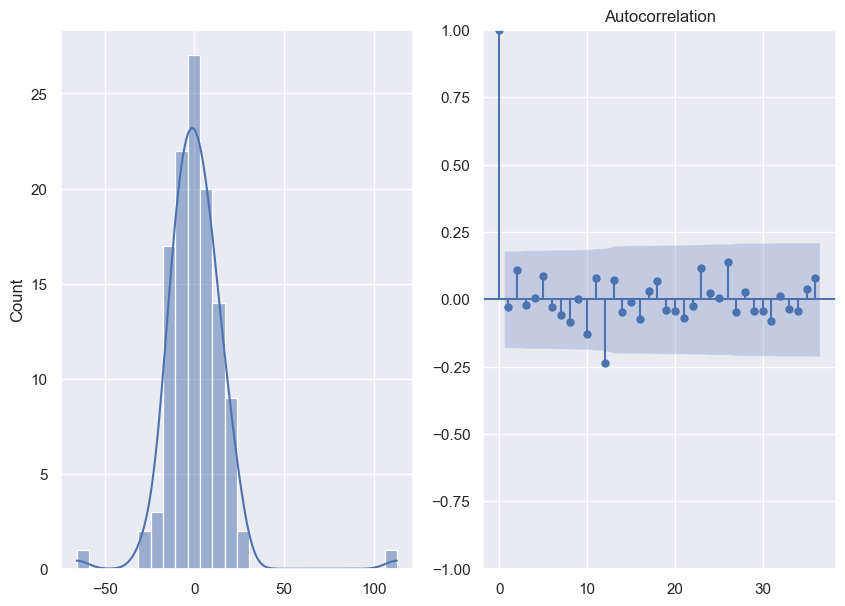

In [287]:
# Visualise the residuals, and check if there is any autocorrelation
residuals = best_model.resid
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
sns.histplot(residuals, kde=True, ax=ax[0])
sm.graphics.tsa.plot_acf(residuals, lags=36, ax=ax[1])
plt.show()

<Axes: xlabel='Date', ylabel='predicted_mean'>

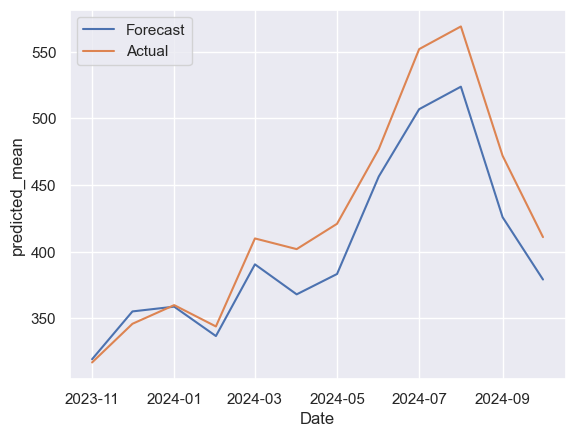

In [288]:
# Forecast the next 12 months
forecast = best_model.forecast(12)
# Plot the forecast
sns.lineplot(x=df_test['Date'], y=forecast, label='Forecast')
sns.lineplot(x=df_test['Date'], y=df_test['Number of Passengers (x1000)'], label='Actual')

In [289]:
sarima = best_model

### IV. Model evaluation

In [290]:
# Compare the two models, with rmse and mape on the traing data

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
     
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

exp_smoothing_rmse = rmse(df_train['Number of Passengers (x1000)'], exp_smoothing.fittedvalues)
exp_smoothing_mape = mape(df_train['Number of Passengers (x1000)'], exp_smoothing.fittedvalues)
sarima_rmse = rmse(df_train['Number of Passengers (x1000)'], sarima.fittedvalues)
sarima_mape = mape(df_train['Number of Passengers (x1000)'], sarima.fittedvalues)

print(f'Exponential Smoothing RMSE: {exp_smoothing_rmse}')
print(f'SARIMA RMSE: {sarima_rmse}')
print(f'Exponential Smoothing MAPE: {exp_smoothing_mape}')
print(f'SARIMA MAPE: {sarima_mape}')


Exponential Smoothing RMSE: 10.681847978897169
SARIMA RMSE: 16.57056426554525
Exponential Smoothing MAPE: 3.5788794439855707
SARIMA MAPE: 5.55151393986819


### V. Forecasting

In [291]:
# Add test data to the models
exp_smoothing = sm.tsa.ExponentialSmoothing(df['Number of Passengers (x1000)'], trend='add', seasonal='mul',seasonal_periods=12).fit(optimized=True)
sarima.extend(df_test)

b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


(100.0, 700.0)

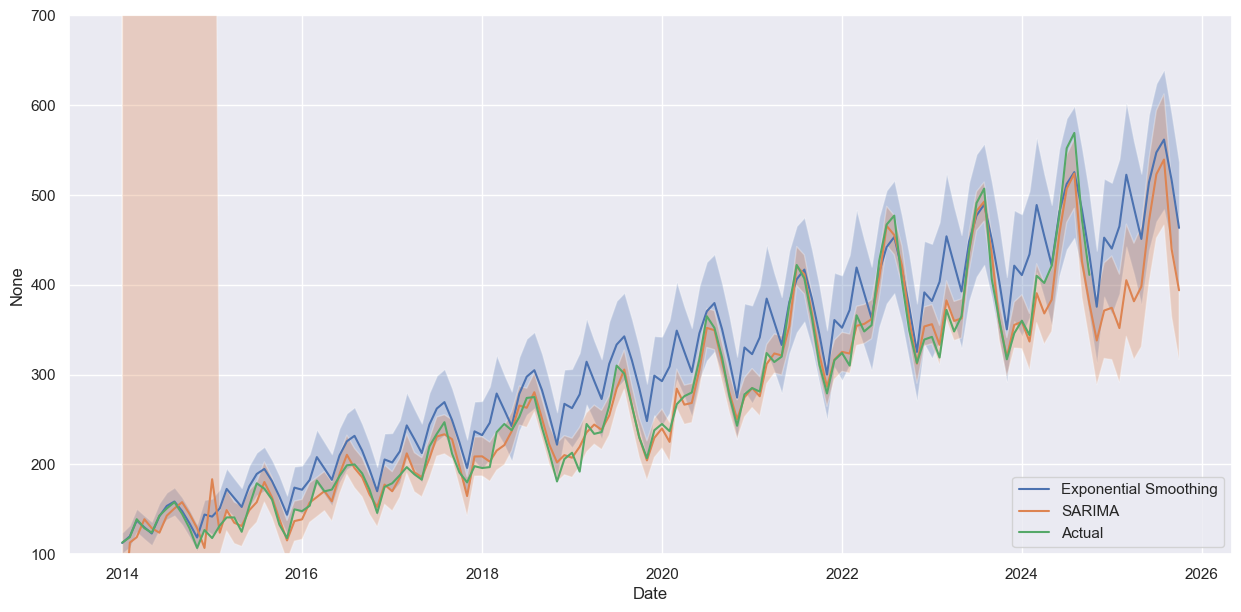

In [293]:
fig, ax = plt.subplots(figsize=(15, 7))

# x is all the data plus 12 months
x = np.append(df['Date'].to_numpy(),(pd.date_range(df['Date'].iloc[-1], periods=12, freq='ME')))

# Forecast the next 12 months using the exponential smoothing model
forecast = exp_smoothing.simulate(len(x), 0, repetitions=1000)
mean_forecast = forecast.mean(axis=1)
lower_bound = mean_forecast - forecast.std(axis=1)
upper_bound = mean_forecast + forecast.std(axis=1)

# y = np.append(exp_smoothing.fittedvalues, mean_forecast)
y = mean_forecast
sns.lineplot(x=x, y=y, label='Exponential Smoothing', ax=ax)
ax.fill_between(x, lower_bound, upper_bound, alpha=0.3)

forecast = sarima.get_prediction(0, len(x) - 1)
sns.lineplot(x=x, y=forecast.predicted_mean, label='SARIMA', ax=ax)
forc = forecast.conf_int()
ax.fill_between(x, forc['lower Number of Passengers (x1000)'], forc['upper Number of Passengers (x1000)'], alpha=0.3)
sns.lineplot(x=df['Date'], y=df['Number of Passengers (x1000)'], label='Actual', ax=ax)

plt.ylim(100, 700)